# Shortest Route Problem

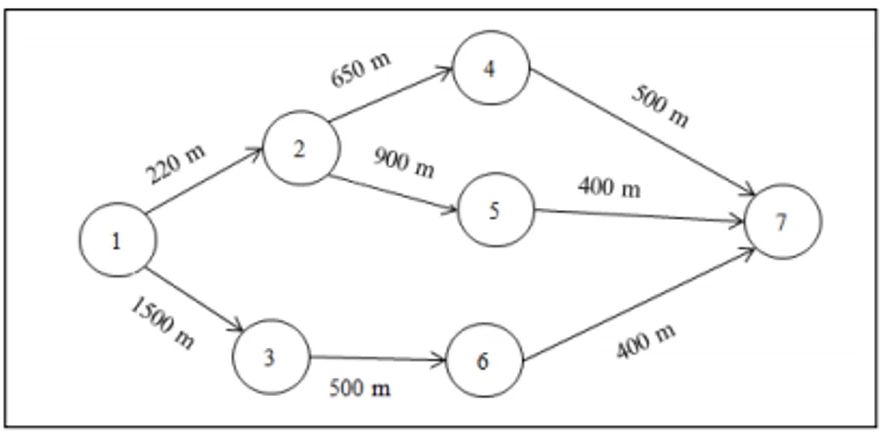

We need to travel from Node 1 to Node 7 using the shortest distance.

<center> Objective Function:$\space\space\large \min \sum b_{i,j}D_{b_{i,j}}$

where $b_{i,j}$ is the binary decision to travel from Node $i$ to Node $j$

and $D_{b_{i,j}}$ is the distance traveled from Node $i$ to Node $j$ if selected.

Moreover, $\sum_{out}b_{i,j} = 1$    origin node

$\sum_{in}b_{i,j} = 1$    destination node

$\sum_{out}b_{i,j} = \sum_{in}b_{i,j}\space\space\forall node\space/\space(origin,destination)$

In [ ]:
# !pip install ortools

In [ ]:
from ortools.sat.python import cp_model
import pandas as pd
import numpy as np

In [ ]:
#inputs

nodes = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Optimization with Python/Exercises/route_inputs.xlsx', sheet_name='nodes')
paths = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Optimization with Python/Exercises/route_inputs.xlsx', sheet_name='paths')
n_nodes = len(nodes)
n_paths = len(paths)
n_nodes, n_paths

(7, 8)

In [ ]:
nodes.head(10)

,node,description
0,1,origin
1,2,middle point
2,3,middle point
3,4,middle point
4,5,middle point
5,6,middle point
6,7,destination


In [ ]:
paths.head(10)

,node_from,node_to,distance
0,1,2,220
1,1,3,1500
2,2,4,650
3,2,5,900
4,4,7,500
5,5,7,400
6,3,6,500
7,6,7,400


Create the model

In [ ]:
model = cp_model.CpModel()


Create the binary variable, $b$

In [ ]:
b = np.zeros(n_paths).tolist()
for p in paths.index:
  b[p] = model.NewBoolVar(f'b[{p}]')

Set up the objective function

In [ ]:
objective_function = sum([b[p]*paths.distance[p] for p in paths.index])
model.Minimize(objective_function)

Add constraints

In [ ]:
node_origin = int(nodes.loc[nodes.description == 'origin', 'node'].iloc[0])
node_destination = int(nodes.loc[nodes.description == 'destination', 'node'].iloc[0])

Add flow conservation constraints

In [ ]:
# Constraint 1: At the origin node, exactly one path must leave.
model.Add(sum(b[p] for p in paths[paths.node_from == node_origin].index) == 1)

# Constraint 2: At the destination node, exactly one path must arrive.
model.Add(sum(b[p] for p in paths[paths.node_to == node_destination].index) == 1)

# Constraint 3: For all other nodes, the number of incoming paths must equal the number of outgoing paths.
for node in nodes[~nodes.description.isin(['origin', 'destination'])]['node']:
    model.Add(sum(b[p] for p in paths[paths.node_to == node].index) == sum(b[p] for p in paths[paths.node_from == node].index))

Create a solver and solve the model

In [ ]:
solver = cp_model.CpSolver()
status = solver.Solve(model)

In [ ]:
print(f'Status: {solver.StatusName(status)}')
print(f'Objective value: {solver.ObjectiveValue()}')

Status: OPTIMAL
Objective value: 1370.0


In [ ]:
paths['activated'] = 0
for p in paths.index:
  paths.activated[p] = solver.Value(b[p])

/tmp/ipython-input-1730164758.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  paths.activated[p] = solver.Value(b[p])
/tmp/ipython-input-1730164758.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are

In [ ]:
paths.head(10)

,node_from,node_to,distance,activated
0,1,2,220,1
1,1,3,1500,0
2,2,4,650,1
3,2,5,900,0
4,4,7,500,1
5,5,7,400,0
6,3,6,500,0
7,6,7,400,0


The optimal (shortest) path is Node 0 --> Node 2 --> Node 4 --> Node 7.